## Traffic incidents in Poland under the influence of alcohol 2016-2022

### 1. data exploration

In [1]:
topicName = 'traffic-incidents-alcohol-pl'
sourceName = "Komenda Główna Policji"
sourceNamePl = "Police Headquarters (PL)"
sourceLink="https://dane.gov.pl/pl/dataset/2737"
fileName= "traffic-incidents-alcohol-pl"
sourceFileExt = 'zip'

In [2]:
import pandas as pd

original_data_path = '../data/raw/traffic-incidents-alcohol-pl/2016.csv'

df = pd.read_csv(original_data_path, 
                   skiprows=4,  encoding='iso-8859-1', sep=';')

df.head()

,Wina,Liczba wypadkï¿½w,Liczba zabitych,Liczba rannych,Liczba kolizji
0,wspï¿½wina uczestnikï¿½w ruchu,36,4,41,70
1,z winy kierujï¿½cego,1686,221,2100,7391
2,z winy pieszego,573,81,500,531
3,Podsumowanie caï¿½kowite,2 295,306,2641,7992


- Index 3 is deleted as it contains sum of columns - data duplication
- First column is not needed -> there will be separate column for every field

### 2. Columns names & descriptions

In [3]:
column_names_descriptions = {
    0: ('year', 
        'year', 
        'rok'),
    1: ('coFaultAccidents', 
        'number of accidents - shared fault of participants', 
        'liczba wypadków - współwina uczestników ruchu'),
    2: ('driverFaultAccidents', 
        "number of accidents - drive's' fault", 
        'liczba wypadków - wina kierowcy'),
    3: ('pedestrianFaultAccidents', 
        "number of accidents - pedestrian's' fault", 
        'liczba wypadków - wina przechodnia'),
    4: ('coFaultKilled', 
        'number of killed - shared fault of participants', 
        'liczba zbitych - współwina uczestników ruchu'),
    5: ('driverFaultKilled', 
        "number of killed - drive's' fault", 
        'liczba zbitych - wina kierowcy'),
    6: ('pedestrianFaultKilled', 
        "number of killed - pedestrian's' fault", 
        'liczba zbitych - wina przechodnia'),
    7: ('coFaultWounded', 
        'number of wounded - shared fault of participants', 
        'liczba rannych - współwina uczestników ruchu'),
    8: ('driverFaultWounded', 
        "number of wounded - drive's' fault", 
        'liczba rannych - wina kierowcy'),
    9: ('pedestrianFaultWounded', 
        "number of wounded - pedestrian's' fault", 
        'liczba rannych - wina przechodnia'),
    10: ('coFaultCollisions', 
        'number of collisions - shared fault of participants', 
        'liczba kolizji - współwina uczestników ruchu'),
    11: ('driverFaultCollisions', 
        "number of collisions - drive's' fault", 
        'liczba kolizji - wina kierowcy'),
    12: ('pedestrianFaultCollisions', 
        "number of collisions - pedestrian's' fault", 
        'liczba kolizji - wina przechodnia'),
}

new_column_names = [t[0] for t in column_names_descriptions.values()]

len(new_column_names)


13

In [4]:
df = pd.DataFrame(columns=new_column_names)

In [5]:
import numpy as np

for index, year  in enumerate(range(2016,2023)):
    original_data_path = f'../data/raw/traffic-incidents-alcohol-pl/{year}.csv'

    temp_df = pd.read_csv(original_data_path, 
                   skiprows=4,  encoding='iso-8859-1', sep=';')
    temp_df.drop(index=3, axis=0, inplace=True)
    temp_df.drop(columns="Wina", axis=1, inplace=True)
    temp_df = pd.melt(temp_df, id_vars=None, var_name='Metric', value_name='Value')
    temp_values = np.insert(temp_df.Value.values,0,year).astype(int)
    df.loc[index] = temp_values
    

In [6]:
df.reset_index(inplace=True, drop=True)
df.head()

,year,coFaultAccidents,driverFaultAccidents,pedestrianFaultAccidents,coFaultKilled,driverFaultKilled,pedestrianFaultKilled,coFaultWounded,driverFaultWounded,pedestrianFaultWounded,coFaultCollisions,driverFaultCollisions,pedestrianFaultCollisions
0,2016,36,1686,573,4,221,81,41,2100,500,70,7391,531
1,2017,42,1603,518,4,198,71,50,1936,454,65,7809,477
2,2018,31,1614,489,2,203,61,41,1965,433,70,8137,444
3,2019,37,1655,397,9,192,64,35,2015,339,76,9034,394
4,2020,18,1656,341,3,216,52,20,1847,300,91,9848,335


In [7]:
df = df.astype(int)

### 3. create db tables

In [8]:
from src.database.connect_db import connect_db

db = connect_db()

cursor = db.cursor()

In [9]:
MAIN_TABLE_NAME = 'trafficIncidentsAlcoholPl'

In [10]:
query = f"CREATE TABLE {MAIN_TABLE_NAME} (year INT PRIMARY KEY, "

for column in df.columns[1:]:
    query += f"{column} INT NOT NULL, "


query = query[:-2] + ")"

In [11]:
try:
    cursor.execute(query)
except:
    print('table already created')

table already created


In [12]:
data = [tuple(row) for index, row in df.iterrows()]

In [13]:
query = f"""
INSERT INTO {MAIN_TABLE_NAME} ({', '.join(df.columns)}) 
VALUES ({', '.join(['%s']*len(df.columns))});
"""

try:
    cursor.executemany(query, data)
except:
    print('data added already')

data added already


In [14]:
cursor.execute(f"""
               SELECT * 
               FROM {MAIN_TABLE_NAME}
               LIMIT 5
               """)
cursor.fetchall()


((2016, 36, 1686, 573, 4, 221, 81, 41, 2100, 500, 70, 7391, 531),
 (2017, 42, 1603, 518, 4, 198, 71, 50, 1936, 454, 65, 7809, 477),
 (2018, 31, 1614, 489, 2, 203, 61, 41, 1965, 433, 70, 8137, 444),
 (2019, 37, 1655, 397, 9, 192, 64, 35, 2015, 339, 76, 9034, 394),
 (2020, 18, 1656, 341, 3, 216, 52, 20, 1847, 300, 91, 9848, 335))

In [15]:
from src.database.create_ds_desc_table import create_ds_desc_table


create_ds_desc_table(MAIN_TABLE_NAME)

An error occurred: (1050, 'target: legal-charts-dev.-.primary: vttablet: rpc error: code = AlreadyExists desc = Table \'trafficIncidentsAlcoholPlDesc\' already exists (errno 1050) (sqlstate 42S01) (CallerID: dwxslyebsjlgo852x54a): Sql: "create table trafficIncidentsAlcoholPlDesc (\\n\\tcolumn_name VARCHAR(255),\\n\\tdescription VARCHAR(255) not null,\\n\\tdescriptionPl VARCHAR(255) not null,\\n\\tPRIMARY KEY (column_name)\\n)", BindVars: {REDACTED}')


In [16]:
data = [row for row in column_names_descriptions.values()]

In [17]:
from src.database.insert_into_ds_desc import insert_into_ds_desc


insert_into_ds_desc(MAIN_TABLE_NAME, data)

data added already
An error occurred: (1062, 'target: legal-charts-dev.-.primary: vttablet: rpc error: code = AlreadyExists desc = Duplicate entry \'year\' for key \'trafficIncidentsAlcoholPlDesc.PRIMARY\' (errno 1062) (sqlstate 23000) (CallerID: dwxslyebsjlgo852x54a): Sql: "insert into trafficIncidentsAlcoholPlDesc(column_name, description, descriptionPl) values (:vtg1 /* VARCHAR */, :vtg2 /* VARCHAR */, :vtg3 /* VARCHAR */), (:vtg4 /* VARCHAR */, :vtg5 /* VARCHAR */, :vtg6 /* VARCHAR */), (:vtg7 /* VARCHAR */, :vtg8 /* VARCHAR */, :vtg9 /* VARCHAR */), ')


### 4. upload files to GCP storage

In [18]:
df_desc = pd.DataFrame(data, 
    columns=['column_name', 
    'description', 
    'descriptionPl'])

In [19]:
df_path = f'../data/processed/{topicName}/{fileName}.csv'
df_path_desc =f'../data/processed/{topicName}/{fileName}-desc.csv'

In [20]:
df.to_csv(df_path, index=False)
df_desc.to_csv(df_path_desc, index=False)

In [21]:
destination = f"{topicName}/{fileName}.csv"
destination_desc = f"{topicName}/{fileName}-desc.csv"
destination_original = f"{topicName}/{fileName}-source.{sourceFileExt}"

In [22]:
from src.utils.upload_file_gpc import upload_file
from src.utils.zip_folder import zip_folder

original_data_path = '../data/raw/traffic-incidents-alcohol-pl/'  
output_path = f'../data/raw/traffic-incidents-alcohol-pl.zip'

zip_folder(original_data_path,output_path)


upload_file(df_path,destination)
upload_file(df_path,destination_desc)
upload_file(output_path,destination_original)

File ../data/processed/traffic-incidents-alcohol-pl/traffic-incidents-alcohol-pl.csv uploaded to legal-charts-datasets/traffic-incidents-alcohol-pl/traffic-incidents-alcohol-pl.csv.
File ../data/processed/traffic-incidents-alcohol-pl/traffic-incidents-alcohol-pl.csv uploaded to legal-charts-datasets/traffic-incidents-alcohol-pl/traffic-incidents-alcohol-pl-desc.csv.
File ../data/raw/traffic-incidents-alcohol-pl.zip uploaded to legal-charts-datasets/traffic-incidents-alcohol-pl/traffic-incidents-alcohol-pl-source.zip.


In [23]:
df.dtypes

year                         int64
coFaultAccidents             int64
driverFaultAccidents         int64
pedestrianFaultAccidents     int64
coFaultKilled                int64
driverFaultKilled            int64
pedestrianFaultKilled        int64
coFaultWounded               int64
driverFaultWounded           int64
pedestrianFaultWounded       int64
coFaultCollisions            int64
driverFaultCollisions        int64
pedestrianFaultCollisions    int64
dtype: object

### 5. data intro

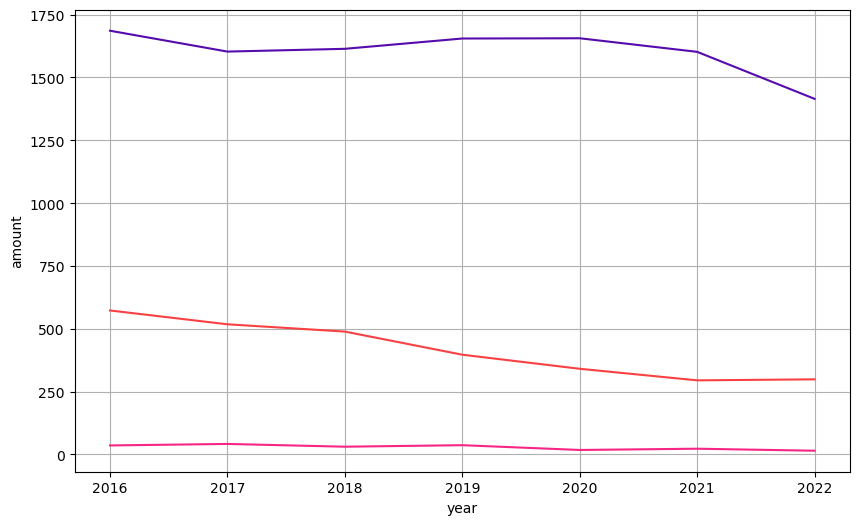

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils.sns_pallete import palette

plt.figure(figsize=(10, 6))

sns.set_palette(palette)

for y in df.columns[1:4]:
    sns.lineplot(data=df, x='year', y=y)

plt.xlabel('year')
plt.ylabel('amount')
plt.grid(True)
plt.show()


In [25]:
db.close()